# Layer-wise Activation Cluster Analysis (LACA) 2 - SVHN: Eval on Adv-Set (BIM)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# BUG FIX, see: https://github.com/pytorch/vision/issues/1938
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# Load libs
import torch
import torch.nn as nn
from torch.nn.functional import adaptive_avg_pool2d
import torchvision
from torchvision import transforms
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
import skimage
from skimage.measure import block_reduce
from umap import UMAP
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
import platform
import warnings
import pprint
from collections import Counter
import time
import math

sns.set()
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('sklearn version:     {}'.format(sklearn.__version__))
print('skimage version:     {}'.format(skimage.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))
print('seaborn version:     {}'.format(sns.__version__))
print('pandas version:      {}'.format(pd.__version__))
print('pickle version:      {}'.format(pickle.format_version))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))
    
if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
torch version:       1.7.0
torchvision version: 0.8.1
sklearn version:     0.23.2
skimage version:     0.17.2
numpy version:       1.19.5
matplotlib version:  3.2.2
seaborn version:     0.11.0
pandas version:      1.1.4
pickle version:      4.0
CUDA available:      False
cuDNN enabled:       True
num gpus:            0


In [2]:
random_seed = 0
torch.manual_seed(random_seed)
np.random.seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)

In [3]:
batch_size_train = 500    # batch size for training
batch_size_test = 1000    # batch size for testing
calibset_size = 750       # size of the calibration set

In [4]:
t = 0.05 # threshold for credibility calculation

## Load Data and Model

### Data

#### Specify Dataset

In [5]:
class CustomTensorDataset(torch.utils.data.Dataset):
    """
    TensorDataset with support for transforms
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
# Training set
trainset = torchvision.datasets.SVHN(
    root='./data', split='train', download=True, transform=transform
)

# Calibration set
orig_testset = torchvision.datasets.SVHN(
    root='./data', split='test', download=True, transform=transform
)
orig_testset_size = len(orig_testset)

testset_size = orig_testset_size - calibset_size
_, calibset = torch.utils.data.random_split(orig_testset, [testset_size, calibset_size])

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


#### Load Data

In [8]:
# Create training data loader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=False, num_workers=2
)

# Load adversarial test data loader
fname = '/Users/lehmann/research/laca/adv_examples/advloader_svhn_bim.pth'
testloader = torch.load(fname)

# Create calib data loader
calibloader = torch.utils.data.DataLoader(
    calibset, batch_size=calibset_size, shuffle=False, num_workers=2
)

In [9]:
print('trainset size: {}'.format(len(trainloader.dataset)))
print('testset size:  {}'.format(len(testloader.dataset)))
print('calibset size: {}'.format(len(calibloader.dataset)))

trainset size: 73257
testset size:  26032
calibset size: 750


#### Display Samples

In [10]:
def show_samples(data, targets):
    data = data.numpy()
    print("tensor shape: " + str(data.shape))
    
    fig = plt.figure()
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        
        img = np.moveaxis(data[i], 0, -1)
        img = img * 0.5 + 0.5  # unnormalize
        plt.imshow(img)
        plt.title("Ground Truth: {}".format(targets[i]))
        
        plt.xticks([])
        plt.yticks([])

##### Training Samples

tensor shape: (500, 3, 32, 32)


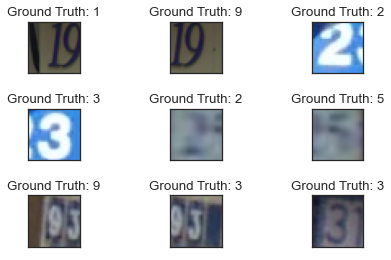

In [11]:
dataiter = enumerate(trainloader)
_, (train_sample_data, train_sample_targets) = next(dataiter)

show_samples(train_sample_data, train_sample_targets)

##### Test Samples

tensor shape: (1000, 3, 32, 32)


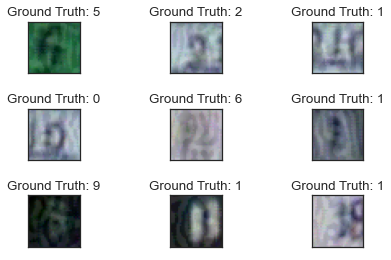

In [12]:
dataiter = enumerate(testloader)
_, (test_sample_data, test_sample_targets) = next(dataiter)

show_samples(test_sample_data, test_sample_targets)

##### Calibration Samples

tensor shape: (750, 3, 32, 32)


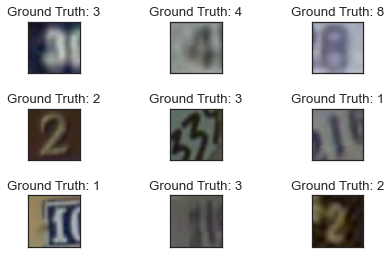

In [13]:
dataiter = enumerate(calibloader)
_, (calib_sample_data, calib_sample_targets) = next(dataiter)

show_samples(calib_sample_data, calib_sample_targets)

### Define Test Functions

In [14]:
def test(model, crit, data_loader, test_losses, test_accs):
    model.eval()
    correct = 0
    test_loss = 0
    
    with torch.no_grad():
        for data in data_loader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            
            # Forward + loss + correct
            outputs = model(inputs)
            test_loss += crit(outputs, targets).item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
          
    dataset_size = len(data_loader.dataset)
    test_loss /= dataset_size
    acc = 100. * correct / dataset_size
    
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, dataset_size, acc
    ))
    
    return test_losses, test_accs

### Network Architecture

In [15]:
class SvhnNet(nn.Module):
    def __init__(self):
        super(SvhnNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=8, stride=2, padding=3)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=6, stride=2)
        self.relu2 = nn.ReLU(True)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=5)
        self.relu3 = nn.ReLU(True)
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = x.view(-1, 512)
        x = self.fc(x)
        return x

### Model Testing

In [16]:
# Create Model
model = SvhnNet()
criterion = nn.CrossEntropyLoss()

# Load Model
model.load_state_dict(
    torch.load("/Users/lehmann/research/laca/models/svhn_model.pth", map_location=torch.device('cpu'))
)

<All keys matched successfully>

In [17]:
model

SvhnNet(
  (conv1): Conv2d(3, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [18]:
layers = {
#    'relu1': {'layer': model.relu1},
    'relu2': {'layer': model.relu2},
    'relu3': {'layer': model.relu3},
    'fc':    {'layer': model.fc}
}

In [19]:
model.eval()

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

In [20]:
def test_final(model, data_loader):
    _, accs = test(model, criterion, data_loader, [], [])
    return accs[0]

In [21]:
test_acc = test_final(model, testloader); test_acc


Test set: Avg. loss: 0.016408, Accuracy: 205/26032 (0.79%)



0.7874923171481254

## Load Projection and Cluster Models

### Load Projection Models

In [22]:
def get_projections(activation_vectors, ext_scaler, ext_reducer):
    if ext_reducer:
        print('## external reducer is used')
        print()
        print()
    
    projections = {}
    projections['projections'] = {}
    projections['targets'] = None
    projections['scaler'] = {}
    projections['reducer'] = {}
    
    layers = list(activation_vectors['activations'].keys())

    for layer_name in layers:
        print('## Computing Projections for Layer {}'.format(layer_name))
        
        # Normalize activations
        layer_activations = activation_vectors['activations'][layer_name]    
        layer_activations_norm = ext_scaler[layer_name].transform(layer_activations)
        
        print('- activations normalized: {}'.format(layer_activations_norm.shape))
        
        # Reduce activations
        proj_temp = layer_activations_norm
        for r in ext_reducer[layer_name]:
            proj_temp = r.transform(proj_temp)
        layer_projections = proj_temp
            
        print('- activations reduced: {}'.format(layer_projections.shape))
        
        # Save projections and reducer
        projections['projections'][layer_name] = layer_projections
        projections['reducer'][layer_name] = ext_reducer[layer_name]
        projections['scaler'][layer_name] = ext_scaler[layer_name]

        # Copy targets
        projections['targets'] = activation_vectors['targets'] 

        print("done!")        
        print()

    return projections


def plot_projects(projections, cluster_labels=None, cluster_centers=None):
    layers = list(projections['projections'].keys())
    
    for layer_name in layers:        
        df = pd.DataFrame()
        df['x'] = projections['projections'][layer_name][:,0]
        df['y'] = projections['projections'][layer_name][:,1]
        
        if cluster_labels is not None:
            df['targets'] = cluster_labels[layer_name]
        else:
            df['targets'] = projections['targets']
    
        plot = sns.lmplot(
            x='x', y='y', data=df, fit_reg=False, hue='targets', height=8, palette='muted', legend=False,
            scatter_kws={'marker': 'D', 's': 50, 'alpha': 0.6}
        ).set_axis_labels('x1','x2')
    
        if cluster_labels is not None:
            plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        else:
            plt.legend(title='Object Class', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            
        if cluster_centers is not None:
            plt.plot(*zip(*cluster_centers[layer_name]), marker='x', color='black', ls='', markersize=14, markeredgewidth=2)
    
        fig = plot.fig
        fig.suptitle('Projections from Layer {}'.format(layer_name), y=1.025, fontsize = 20)

In [23]:
fname = '/Users/lehmann/research/laca/exp1/exp1_0/laca_svhn_baseline_projections.pkl'

In [24]:
with open(fname, 'rb') as pickle_file:
    loaded_baseline_projections = pickle.load(pickle_file)

In [25]:
print('targets: {}'.format(loaded_baseline_projections['targets'].shape))
print()

for layer in layers:
    print('## layer {}'.format(layer))
    print('projections: {}'.format(loaded_baseline_projections['projections'][layer].shape))
    print('scaler:      {}'.format(loaded_baseline_projections['scaler'][layer]))
    print('reducer:     {}'.format(loaded_baseline_projections['reducer'][layer]))
    print()

targets: (73257,)

## layer relu2
projections: (73257, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer relu3
projections: (73257, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer fc
projections: (73257, 2)
scaler:      StandardScaler()
reducer:     [UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]



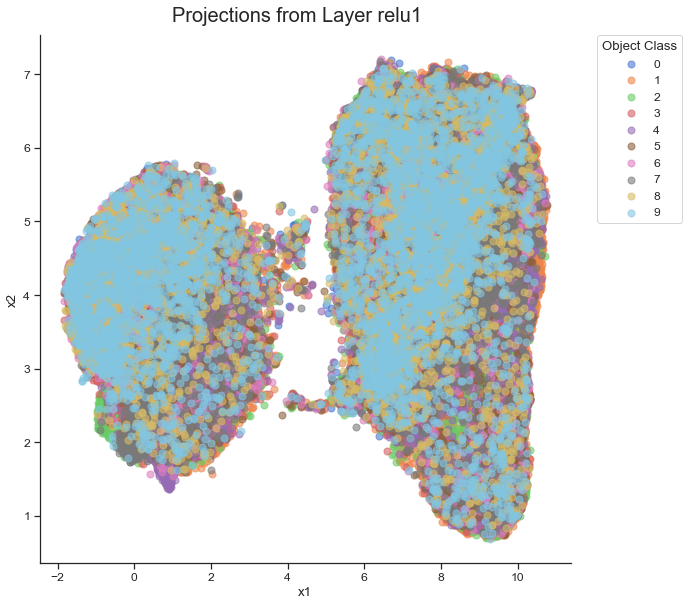

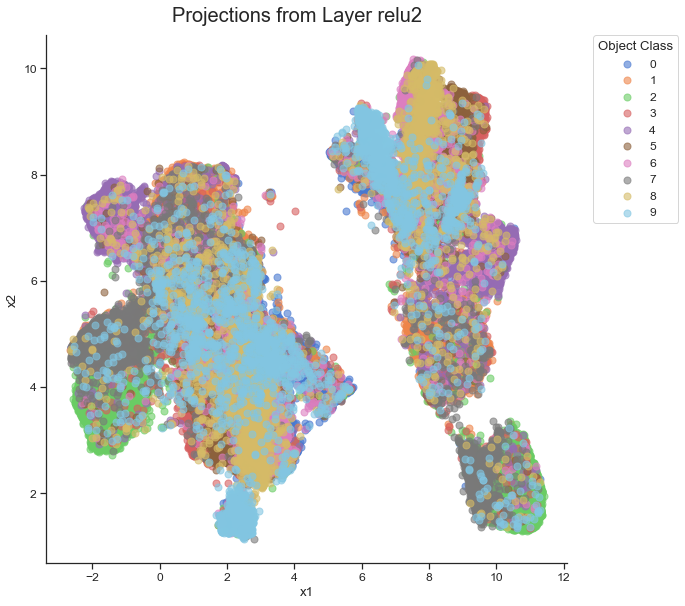

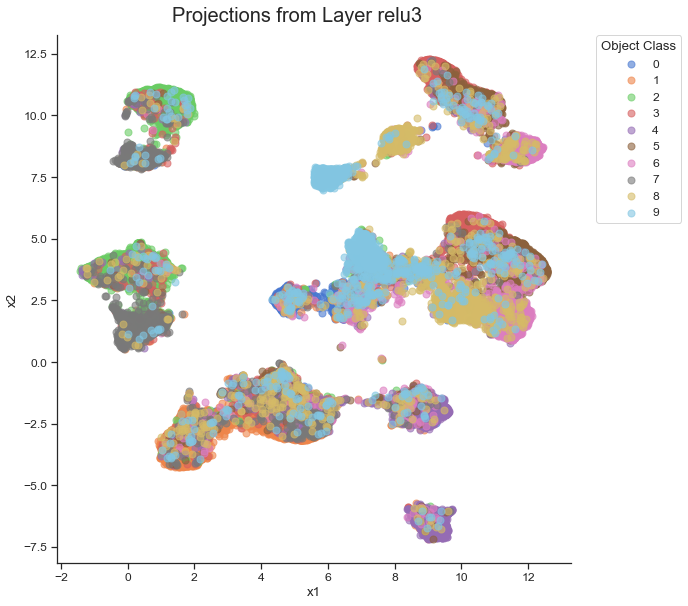

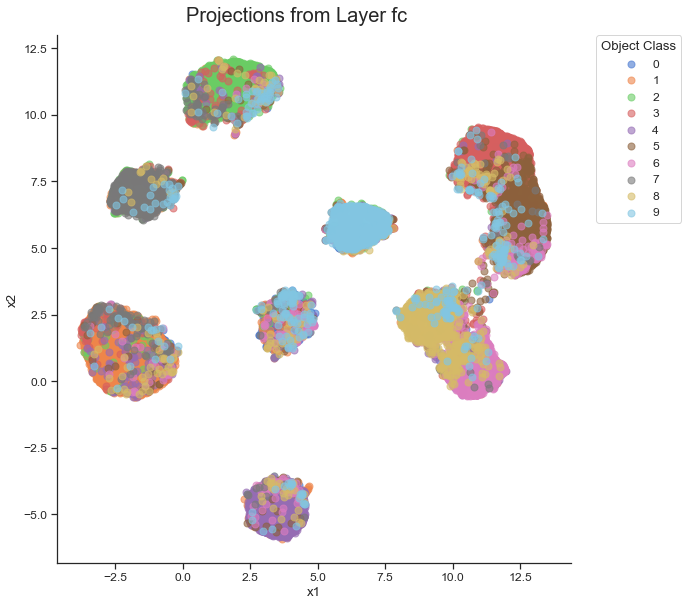

In [26]:
plot_projects(loaded_baseline_projections)

### Load Cluster Models

In [27]:
fname = '/Users/lehmann/research/laca/exp1/exp1_0/laca_svhn_baseline_clusters.pkl'

In [28]:
with open(fname, 'rb') as pickle_file:
    loaded_baseline_clusters = pickle.load(pickle_file)

In [29]:
for layer in layers:
    print('## layer {}'.format(layer))
    print('cluster labels:  {}'.format(loaded_baseline_clusters['cluster_labels'][layer].shape))
    print('cluster centers: {}'.format(loaded_baseline_clusters['cluster_centers'][layer].shape))
    print('clusterer:       {}'.format(loaded_baseline_clusters['clusterer'][layer]))
    print()

## layer relu2
cluster labels:  (73257,)
cluster centers: (5, 2)
clusterer:       KMeans(n_clusters=5)

## layer relu3
cluster labels:  (73257,)
cluster centers: (12, 2)
clusterer:       KMeans(n_clusters=12)

## layer fc
cluster labels:  (73257,)
cluster centers: (10, 2)
clusterer:       KMeans(n_clusters=10)



In [30]:
pprint.pprint(loaded_baseline_clusters['stats'])

{'fc': {0: {0: 0.0031231700175678315,
            1: 0.008393519422213547,
            2: 0.01073589693538942,
            3: 0.02439976576224868,
            4: 0.008003123170017569,
            5: 0.013468670700761272,
            6: 0.026742143275424558,
            7: 0.0011711887565879367,
            8: 0.8928362287722038,
            9: 0.0111262931875854},
        1: {0: 0.005158817893728351,
            1: 0.9626354189697104,
            2: 0.0038322647210553467,
            3: 0.006190581472474021,
            4: 0.006337976269437689,
            5: 0.0021372245559731743,
            6: 0.0024320141499005084,
            7: 0.006853858058810524,
            8: 0.003021593337755177,
            9: 0.0014002505711548383},
        2: {0: 0.001430615164520744,
            1: 0.007439198855507869,
            2: 0.9611826418693371,
            3: 0.009918931807343824,
            4: 0.0031473533619456365,
            5: 0.001430615164520744,
            6: 0.0010491177873152122,
 

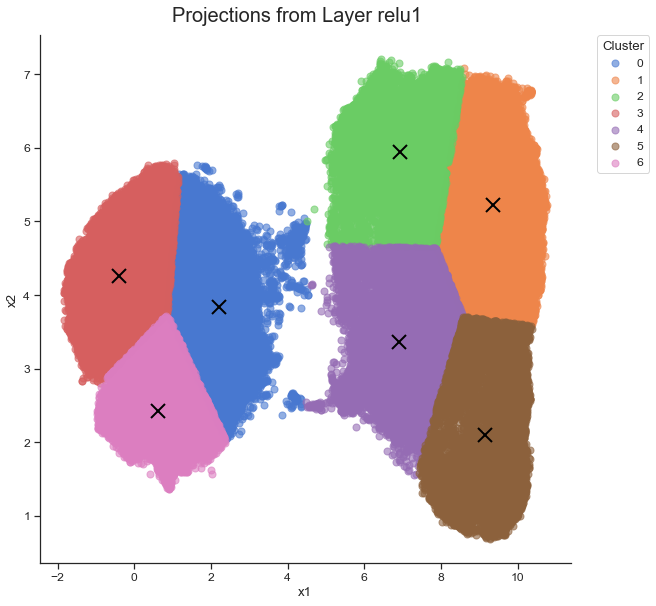

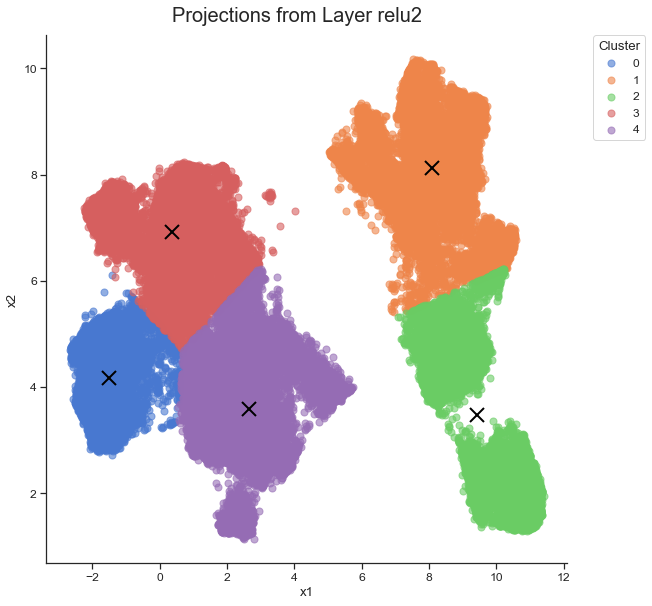

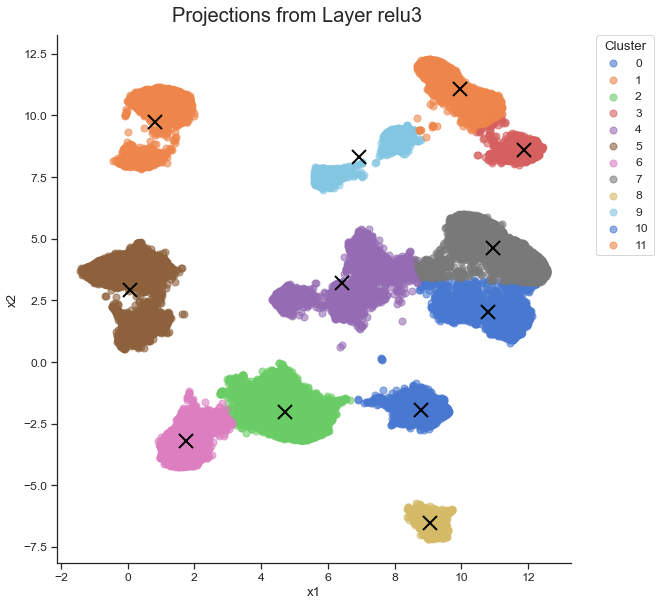

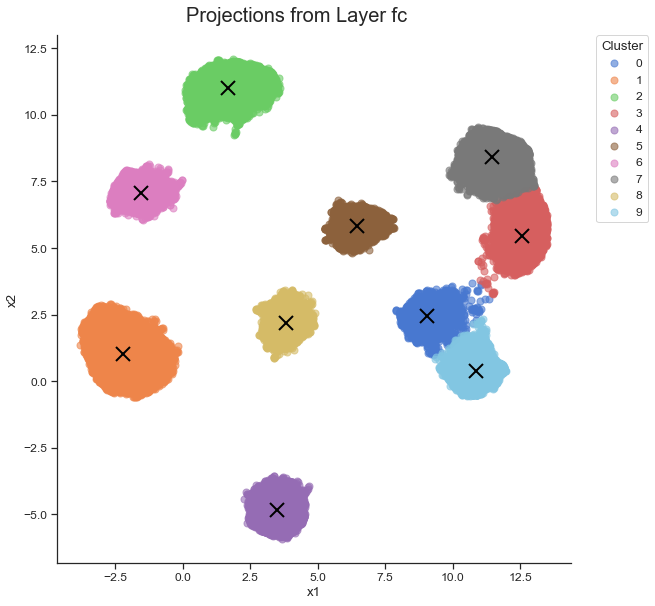

In [31]:
plot_projects(
    loaded_baseline_projections, 
    loaded_baseline_clusters['cluster_labels'], 
    loaded_baseline_clusters['cluster_centers']
)

### Get Layer Weights

In [32]:
def get_weights(stats):
    weights = {}
    sum_weights = 0.0
    
    # for each layer get the layer weight
    for layer_name in layers:
        weights[layer_name] = get_layer_weight(stats, layer_name)
        sum_weights += get_layer_weight(stats, layer_name)
       
    # normalize the weights and round each normalized weight to 2 decimal places
    for layer_name in weights:
        weights[layer_name] = round(weights[layer_name] / sum_weights, 2)
    
    return weights


def get_layer_weight(stats, layer_name):
    max_diffs = []
    
    # go through all clusters of the layer and find the difference between the class with the 
    # highest and the class with the second highest percentage (difference of the two percentages)
    for i in loaded_baseline_clusters['stats'][layer_name]:
        
        # find the class with the highest percentage and its percentage
        max1 = 0.0
        argmax1 = -1
        for j in loaded_baseline_clusters['stats'][layer_name][i]:
            if loaded_baseline_clusters['stats'][layer_name][i][j] > max1:
                max1 = loaded_baseline_clusters['stats'][layer_name][i][j]
                argmax1 = j
           
        # find the second highest percentage
        max2 = 0.0
        for j in loaded_baseline_clusters['stats'][layer_name][i]:
            if loaded_baseline_clusters['stats'][layer_name][i][j] > max2 and j != argmax1:
                max2 = loaded_baseline_clusters['stats'][layer_name][i][j]
            
        max_diffs += [max1 - max2]

    # take the average of the differences to obtain the layer weight
    layer_weight = sum(max_diffs) / len(max_diffs)
    return round(layer_weight, 2)

In [33]:
layer_weights = get_weights(loaded_baseline_clusters['stats'])  
print(layer_weights)
print(f"sum = {sum(layer_weights.values())}")

{'relu2': 0.09, 'relu3': 0.31, 'fc': 0.6}
sum = 1.0


## Get Class Label Distribution CalibSet

### Fetch Activations

In [34]:
def fetch_activations(dataloader, model, layers): 
    activations = {}
    activations['activations'] = {}
    activations['targets'] = []
    
    handlers = {}
    
    # Define hook
    def get_activations(layer_name):
        def hook(model, input, output):
            activations['activations'][layer_name].append(output.squeeze().detach().cpu().numpy())
        return hook
    
    # Register Hooks
    print('## Registering Hooks')
    
    for layer_name in layers:
        print('Register Hook for Layer {}'.format(layer_name))
        activations['activations'][layer_name] = []
        handlers[layer_name] = layers[layer_name]['layer'].register_forward_hook(get_activations(layer_name))
    
    print()
        
    # Fetch activations
    print('## Fetching Activations')
    targets = []
    
    for i, batch in enumerate(dataloader):
        print('Processing Batch {}'.format(i))

        if use_cuda:
            batch = batch.cuda()
            
        _ = model(batch[0])

        if len(batch) > 1:
            activations['targets'].append(batch[1].detach().cpu().numpy())
            
    print('- activations fetched')
    print()
     
    # Concetenate batch activations/targets and remove hooks
    print('## Removing Hooks')
    activations['targets'] = np.concatenate(activations['targets'])
    
    for layer_name in layers:
        print('Remove Hook from Layer {}'.format(layer_name))
        activations['activations'][layer_name] = np.concatenate(activations['activations'][layer_name])
        handlers[layer_name].remove()
        
    print()
    print("done!")        
    print()
        
    return activations

In [35]:
activations_calib = fetch_activations(calibloader, model, layers)

## Registering Hooks
Register Hook for Layer relu2
Register Hook for Layer relu3
Register Hook for Layer fc

## Fetching Activations
Processing Batch 0
- activations fetched

## Removing Hooks
Remove Hook from Layer relu2
Remove Hook from Layer relu3
Remove Hook from Layer fc

done!



In [36]:
print('targets: {}'.format(activations_calib['targets'].shape))
print()

for layer in layers:
    print('## layer {}'.format(layer))
    print('activations: {}'.format(activations_calib['activations'][layer].shape))
    print()

targets: (750,)

## layer relu2
activations: (750, 128, 6, 6)

## layer relu3
activations: (750, 128, 2, 2)

## layer fc
activations: (750, 10)



### Transform Activations to Vectors

In [37]:
def transform_acts2vec(activations, pool=None):
    activation_vectors = {}
    activation_vectors['activations'] = {}
    activation_vectors['targets'] = None
    
    layers = list(activations['activations'].keys())
    
    for layer_name in layers:
        print('## Transforming Activations to Vector Form for Layer {}'.format(layer_name))
        
        # Transform activations
        layer_activations = activations['activations'][layer_name]
        layer_activation_vectors = []
        
        for i in range(layer_activations.shape[0]):
            sample_activation_vector = transform_acts2vec_from_sample(layer_activations[i], pool)            
            layer_activation_vectors.append(sample_activation_vector)
                        
        layer_activation_vectors = np.array(layer_activation_vectors)    
        print('- activations transformed: {}'.format(layer_activation_vectors.shape))
        
        # Save activations vectors
        activation_vectors['activations'][layer_name] = layer_activation_vectors
        
        # Copy targets
        activation_vectors['targets'] = activations['targets']

        print("done!")        
        print()
    
    return activation_vectors


def transform_acts2vec_from_sample(sample_activations, pool=(2,2)):
    if len(sample_activations.shape) == 3:
        if pool is None:
            sample_activations = sample_activations.flatten()
        else:
            sample_activations = np.array([
                block_reduce(act_map, pool, np.mean) for act_map in sample_activations
            ]).flatten()
                        
    return sample_activations

In [38]:
activation_vectors_calib = transform_acts2vec(activations_calib, None)

## Transforming Activations to Vector Form for Layer relu2
- activations transformed: (750, 4608)
done!

## Transforming Activations to Vector Form for Layer relu3
- activations transformed: (750, 512)
done!

## Transforming Activations to Vector Form for Layer fc
- activations transformed: (750, 10)
done!



In [39]:
print('targets: {}'.format(activation_vectors_calib['targets'].shape))
print()

for layer in layers:
    print('## layer {}'.format(layer))
    print('activations: {}'.format(activation_vectors_calib['activations'][layer].shape))
    print()

targets: (750,)

## layer relu2
activations: (750, 4608)

## layer relu3
activations: (750, 512)

## layer fc
activations: (750, 10)



### Get Projections

In [40]:
projections_calib = get_projections(
    activation_vectors_calib, 
    ext_scaler=loaded_baseline_projections['scaler'], 
    ext_reducer=loaded_baseline_projections['reducer']
)

## external reducer is used


## Computing Projections for Layer relu2
- activations normalized: (750, 4608)
- activations reduced: (750, 2)
done!

## Computing Projections for Layer relu3
- activations normalized: (750, 512)
- activations reduced: (750, 2)
done!

## Computing Projections for Layer fc
- activations normalized: (750, 10)
- activations reduced: (750, 2)
done!



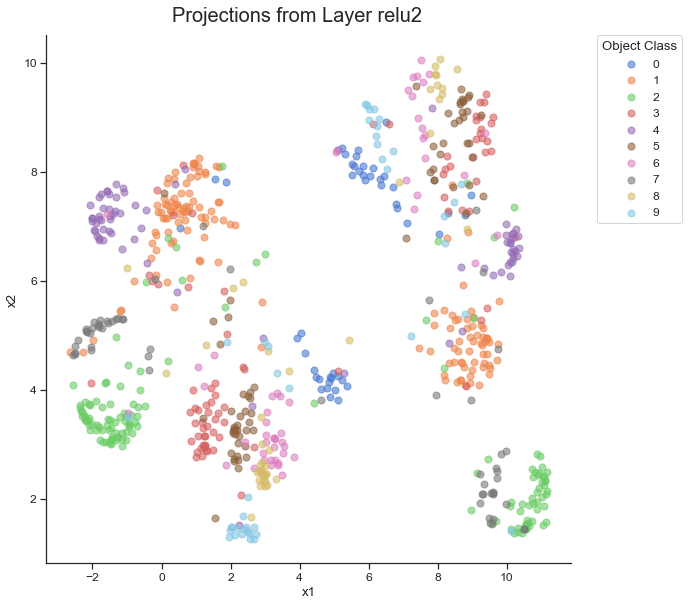

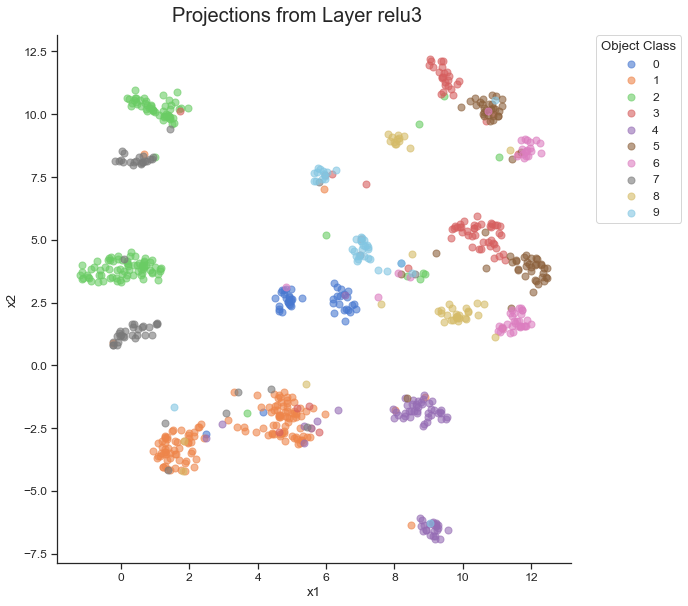

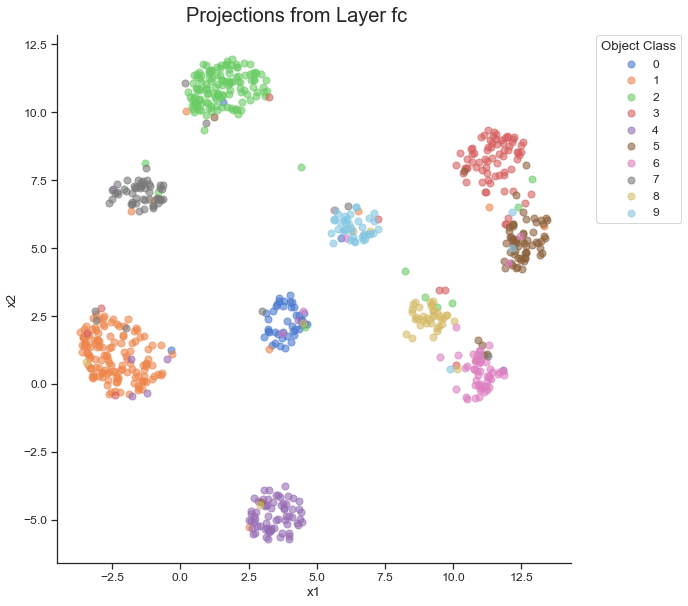

In [41]:
plot_projects(projections_calib)

### Get Cluster Labels

In [42]:
def get_labels(projs, clusterer):
    labels = {}
    for layer_name in layers:
        labels[layer_name] = clusterer[layer_name].predict(projs[layer_name])
        
    return labels

In [43]:
labels_calib = get_labels(projections_calib['projections'], loaded_baseline_clusters['clusterer'])

In [44]:
for layer in layers:
    print('## layer {}'.format(layer))
    print('cluster labels:  {}'.format(labels_calib[layer].shape))
    print()

## layer relu2
cluster labels:  (750,)

## layer relu3
cluster labels:  (750,)

## layer fc
cluster labels:  (750,)



### Calculate Class Label Distribution

In [45]:
def get_class_label_calib_distro(stats, projections, labels, t=0.01):
    class_label_distro = {}
    num_samples = len(projections['targets'])

    # for each layer get a dict of (key: class, value: label list) for the calib set
    for layer_name in layers:
        class_label_distro[layer_name] = {}
        
        # for each sample check its label and add it to the dict if it is not an outlier
        for i in range(num_samples):
            label = labels[layer_name][i]
            target = projections['targets'][i]
            
            # add label only if that class is not an outlier in that cluster
            if target in stats[layer_name][label] and stats[layer_name][label][target] > t:
                if target in class_label_distro[layer_name].keys():
                    class_label_distro[layer_name][target] += [label]
                else:
                    class_label_distro[layer_name][target] = [label]
          
    # for each layer get a dict of (key: class, value: dict of (key: label, value: percentage)) of calib set
    for layer_name in layers:
        
        # for each class calculate the percentage of each label
        for c in class_label_distro[layer_name]:
            total = len(class_label_distro[layer_name][c])
            counts = dict(Counter(class_label_distro[layer_name][c]))
        
            for i in counts:
                counts[i] /= total
            
            class_label_distro[layer_name][c] = counts
            
    return class_label_distro

In [46]:
class_label_calib_distro = get_class_label_calib_distro(
    loaded_baseline_clusters['stats'],
    projections_calib, 
    labels_calib,
    t
)

In [47]:
class_label_calib_distro

{'relu2': {3: {1: 0.358974358974359,
   4: 0.5256410256410257,
   3: 0.11538461538461539},
  4: {3: 0.6268656716417911, 1: 0.373134328358209},
  8: {4: 0.6666666666666666, 1: 0.3333333333333333},
  2: {2: 0.4274193548387097, 0: 0.5725806451612904},
  1: {3: 0.5714285714285714, 2: 0.42857142857142855},
  7: {0: 0.5384615384615384, 2: 0.46153846153846156},
  9: {1: 0.42105263157894735, 4: 0.5789473684210527},
  5: {4: 0.5230769230769231, 1: 0.47692307692307695},
  6: {4: 0.5961538461538461, 1: 0.40384615384615385},
  0: {4: 0.4090909090909091, 1: 0.5909090909090909}},
 'relu3': {4: {10: 0.6363636363636364, 8: 0.36363636363636365},
  8: {0: 0.6756756756756757, 9: 0.32432432432432434},
  2: {1: 0.40625, 5: 0.59375},
  3: {7: 0.6231884057971014, 11: 0.37681159420289856},
  1: {2: 0.5652173913043478, 6: 0.43478260869565216},
  7: {5: 0.5686274509803921, 1: 0.43137254901960786},
  9: {9: 0.3333333333333333, 4: 0.6666666666666666},
  6: {0: 0.6326530612244898, 3: 0.3673469387755102},
  5: {7: 

## Get Testset Credibility

### Fetch Activations

In [48]:
start_fetch_act = time.time()

activations_test = fetch_activations(testloader, model, layers)

end_fetch_act = time.time()

## Registering Hooks
Register Hook for Layer relu2
Register Hook for Layer relu3
Register Hook for Layer fc

## Fetching Activations
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
Processing Batch 10
Processing Batch 11
Processing Batch 12
Processing Batch 13
Processing Batch 14
Processing Batch 15
Processing Batch 16
Processing Batch 17
Processing Batch 18
Processing Batch 19
Processing Batch 20
Processing Batch 21
Processing Batch 22
Processing Batch 23
Processing Batch 24
Processing Batch 25
Processing Batch 26
- activations fetched

## Removing Hooks
Remove Hook from Layer relu2
Remove Hook from Layer relu3
Remove Hook from Layer fc

done!



In [49]:
print('targets: {}'.format(activations_test['targets'].shape))
print()

for layer in layers:
    print('## layer {}'.format(layer))
    print('activations: {}'.format(activations_test['activations'][layer].shape))
    print()

targets: (26032,)

## layer relu2
activations: (26032, 128, 6, 6)

## layer relu3
activations: (26032, 128, 2, 2)

## layer fc
activations: (26032, 10)



#### Display CalibSet Class Distribution

(array([ 47., 144., 137.,  82.,  74.,  68.,  54.,  59.,  43.,  42.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

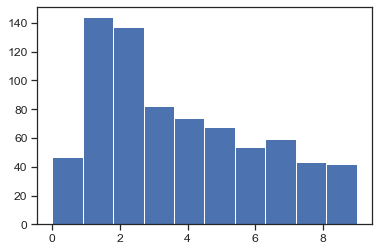

In [50]:
plt.hist(list(activations_calib['targets']))

#### Display Testset Class Distribution

(array([1744., 5099., 4149., 2882., 2523., 2384., 1977., 2019., 1660.,
        1595.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

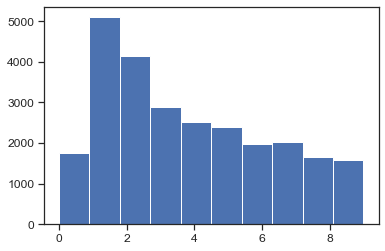

In [51]:
plt.hist(list(activations_test['targets']))

### Transform Activations to Vectors

In [52]:
start_transf = time.time()

activation_vectors_test = transform_acts2vec(activations_test, None)

end_transf = time.time()

## Transforming Activations to Vector Form for Layer relu2
- activations transformed: (26032, 4608)
done!

## Transforming Activations to Vector Form for Layer relu3
- activations transformed: (26032, 512)
done!

## Transforming Activations to Vector Form for Layer fc
- activations transformed: (26032, 10)
done!



In [53]:
print('targets: {}'.format(activation_vectors_test['targets'].shape))
print()

for layer in layers:
    print('## layer {}'.format(layer))
    print('activations: {}'.format(activation_vectors_test['activations'][layer].shape))
    print()

targets: (26032,)

## layer relu2
activations: (26032, 4608)

## layer relu3
activations: (26032, 512)

## layer fc
activations: (26032, 10)



### Get Projections

In [54]:
start_proj = time.time()

projections_test = get_projections(
    activation_vectors_test, 
    ext_scaler=loaded_baseline_projections['scaler'], 
    ext_reducer=loaded_baseline_projections['reducer']
)

end_proj = time.time()

## external reducer is used


## Computing Projections for Layer relu2
- activations normalized: (26032, 4608)
- activations reduced: (26032, 2)
done!

## Computing Projections for Layer relu3
- activations normalized: (26032, 512)
- activations reduced: (26032, 2)
done!

## Computing Projections for Layer fc
- activations normalized: (26032, 10)
- activations reduced: (26032, 2)
done!



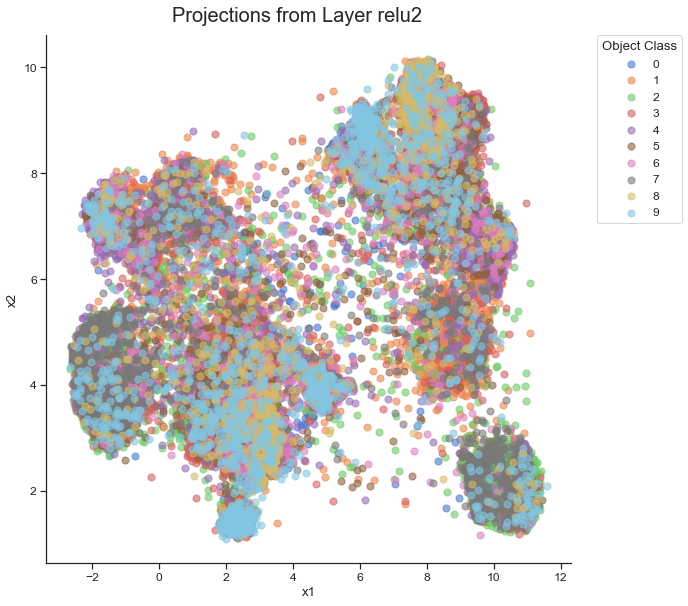

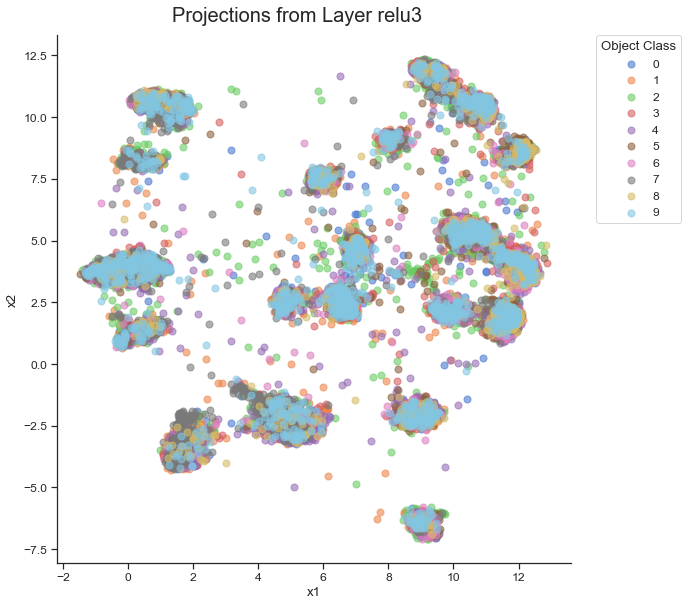

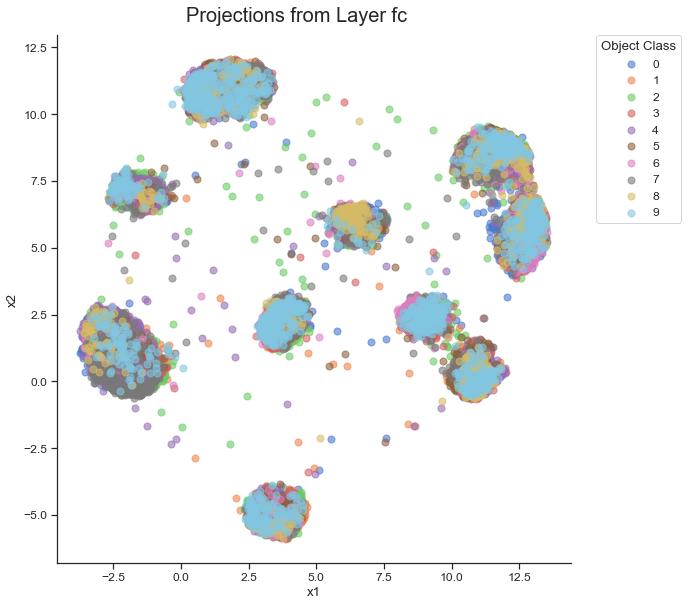

In [55]:
plot_projects(projections_test)

### Get Cluster Labels

In [56]:
start_cluster = time.time()

labels_test = get_labels(projections_test['projections'], loaded_baseline_clusters['clusterer'])

end_cluster = time.time()

In [57]:
for layer in layers:
    print('## layer {}'.format(layer))
    print('cluster labels:  {}'.format(labels_test[layer].shape))
    print()

## layer relu2
cluster labels:  (26032,)

## layer relu3
cluster labels:  (26032,)

## layer fc
cluster labels:  (26032,)



### Calculate Credibility

In [58]:
def calc_test_credibs(stats, layer_weights, class_label_calib_distro, projections, labels, t=0.01):
    num_samples = len(projections['targets'])
    credib_scores = np.array([0.0]*num_samples)
    
    # for each test sample calculate credib score
    for i in range(num_samples):
        class_intersect = []
        
        # for each layer get the classes of the cluster the test sample is in 
        # and finally get the class intersection over all layers
        for layer_name in layers:
            label = labels[layer_name][i]
            
            # only take the class if the percentage of that class in the training data is > t
            classes = [c for c in stats[layer_name][label].keys() if stats[layer_name][label][c] > t]
            
            # take the intesection of the classes
            if len(class_intersect) == 0:
                class_intersect += classes
            else:
                class_intersect = [c for c in class_intersect if c in classes]
        
        # if the class intersection is empty, the credib score is 0, otherwise calculate the credib score
        if len(class_intersect) == 0:
            credib_scores[i] = 0.0
        else:
            class_credibs = {}
            
            # for each remaining class calculate the credib score
            for c in class_intersect:
                class_credibs[c] = 0.0
                
                # for each layer calculate the credib score of that class
                for layer_name in layers:
                    label = labels[layer_name][i]
                    
                    # if the class is in the cluster of the calib data of that layer, take it, otherwise don't
                    # (if it is taken, it is multiplied with the layer weight to obtain a weighted average at the end)
                    if label in class_label_calib_distro[layer_name][c]:
                        class_credibs[c] += class_label_calib_distro[layer_name][c][label] * layer_weights[layer_name]
                    else:
                        class_credibs[c] = 0.0
                        break
                
            # use the max credib score among the remaining classes as the final credib score for that test sample
            credib_scores[i] = max(class_credibs.values())
    
    return credib_scores  

In [59]:
start_credib = time.time()

test_credibs = calc_test_credibs(
    loaded_baseline_clusters['stats'],  
    layer_weights,
    class_label_calib_distro,
    projections_test,
    labels_test,
    t
)

end_credib = time.time()

In [60]:
num_samples = len(projections_test['targets'])
total_credib = np.sum(np.array(test_credibs)) / num_samples
print(total_credib)

0.6065743290891775


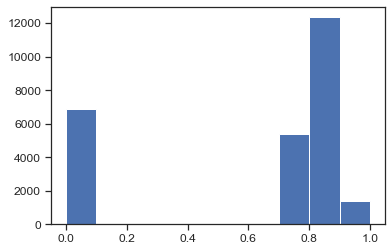

In [61]:
plt.hist(test_credibs, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]);

## Time Measurements

In [62]:
time_fetch_act = end_fetch_act - start_fetch_act
time_transf = end_transf - start_transf
time_proj = end_proj - start_proj
time_cluster = end_cluster - start_cluster
time_credib = end_credib - start_credib

time_total = time_fetch_act + time_transf + time_proj + time_cluster + time_credib

print(f"Fetching Activations:     {time_fetch_act}")
print(f"Transforming Activations: {time_transf}")
print(f"Creating Projections:     {time_proj}")
print(f"Getting Cluster Labels:   {time_cluster}")
print(f"Calculating Credibility:  {time_credib}")
print()
print(f"total: {time_total}")

Fetching Activations:     12.957099914550781
Transforming Activations: 0.7377729415893555
Creating Projections:     14.144810914993286
Getting Cluster Labels:   0.002830028533935547
Calculating Credibility:  0.22116398811340332

total: 28.06367778778076
